# Plot the tracks from Angleur
## Pre-processing
```bash
./fit2gpx # convert fit to gpx format
./cleangpx.bash /home/ctroupin/data/GPX/Garmin-Gpx/

```

In [5]:
import os
import glob
import numpy as np
import hikinggc
import cmocean
from geopy import distance
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import contextily as ctx
datacrs = ccrs.PlateCarree()
proj = ccrs.epsg("3857")
import logging
logger = logging.getLogger()
logging.info("start")

from matplotlib.font_manager import FontProperties

## Configuration
### Fonts

In [8]:
fa_dir = r"/home/ctroupin/.fonts/fontawesome-free-6.4.0-desktop/otfs"
fontfile = os.path.join(fa_dir, "Font Awesome 6 Free-Solid-900.otf")
if os.path.exists(fontfile):
    fp1 = FontProperties(fname=fontfile)
else:
    logger.warn("The fontawesome file cannot be found")
    
fonttitle = FontProperties(fname="/home/ctroupin/.fonts/TransonicDemoRegular.ttf")

### Files and directories

In [26]:
datadir = "/data/GPX/Garmin/proc/"
datadir = "/home/ctroupin/data/GPX/Garmin-Gpx/"
basemapdir = "../data/basemaps/"
figdir = "../images/"
datafilelist = sorted(glob.glob(os.path.join(datadir, "angleur*gpx")))
NN = 50
origin = (50.61279, 5.59965)
domainangleur = [5.553, 5.607, 50.579, 50.616]
logger.info(f"Found {len(datafilelist)} files")

### Extract the basemaps

In [15]:
zoomlevel = 14
domain = domainangleur

os.makedirs(basemapdir, exist_ok=True)
backgroundfile = os.path.join(basemapdir, "Angleur_OSM_14.tif")

if os.path.exists(backgroundfile):
    logger.info("Background raster already downloaded")
else:
    _ = ctx.bounds2raster(domain[0], domain[2], domain[1], domain[3],
                 ll=True,
                 path=backgroundfile,
                 source=ctx.providers.OpenStreetMap.Mapnik, zoom=zoomlevel,
                )

In [16]:
backgroundfile2 = os.path.join(basemapdir, "Angleur_Carto_14.tif")

if os.path.exists(backgroundfile2):
    logger.info("Background raster already downloaded")
else:
    _ = ctx.bounds2raster(domain[0], domain[2], domain[1], domain[3],
                 ll=True,
                 path=backgroundfile2,
                 source=ctx.providers.CartoDB.Positron, zoom=zoomlevel,
                )

In [17]:
backgroundfile3a = os.path.join(basemapdir, "Angleur_Carto_Dark_14.tif")

if os.path.exists(backgroundfile3a):
    logger.info("Background raster already downloaded")
else:
    _ = ctx.bounds2raster(domain[0], domain[2], domain[1], domain[3],
                 ll=True,
                 path=backgroundfile3a,
                 source=ctx.providers.CartoDB.DarkMatterNoLabels, zoom=zoomlevel,
                )

backgroundfile3b = os.path.join(basemapdir, "Angleur_Carto_DarkLabels_14.tif")

if os.path.exists(backgroundfile3b):
    logger.info("Background raster already downloaded")
else:
    _ = ctx.bounds2raster(domain[0], domain[2], domain[1], domain[3],
                 ll=True,
                 path=backgroundfile3b,
                 source=ctx.providers.CartoDB.DarkMatterOnlyLabels, zoom=zoomlevel,
                )
    
backgroundfile3c = "../data/basemaps/Angleur_Carto_DarkLabels_15.tif"

if os.path.exists(backgroundfile3c):
    logger.info("Background raster already downloaded")
else:
    _ = ctx.bounds2raster(domain[0], domain[2], domain[1], domain[3],
                 ll=True,
                 path=backgroundfile3c,
                 source=ctx.providers.CartoDB.DarkMatterOnlyLabels, zoom=15,
                )

In [18]:
background = hikinggc.Visible()
background.read_geotiff(backgroundfile)
background2 = hikinggc.Visible()
background2.read_geotiff(backgroundfile2)
background3a = hikinggc.Visible()
background3a.read_geotiff(backgroundfile3a)
background3b = hikinggc.Visible()
background3b.read_geotiff(backgroundfile3b)
background3c = hikinggc.Visible()
background3c.read_geotiff(backgroundfile3c)

In [19]:
def getcolordist(dist):
    if dist < 5.0:
        thecolor = "#167000"
    elif dist < 5.5:
        thecolor = "#FFEB2D"
    elif dist < 6.:
        thecolor = "#FFA22D"
    else:
        thecolor = "#FF2D2D"
        
    return thecolor

In [20]:
colordict = {"< 5 km": "#167000",
             "5 — 5.5 km": "#FFEB2D",
             "5.5 — 6 km": "#FFA22D",
             "> 6 km": "#FF2D2D"
            }

def add_legend(colordict, ax, loc=2, ncol=2, legtitle=None, zorder=15):
    """Add a legend on the current ax using the color dictionary,
    which related a text and a color.
    
    ## Example
    
    colordict = {"< 1%": "#ffffe5",
             "1-5%": "#f7fcb9",
             "5-10%": "#d9f0a3",
             "10-15%": "#addd8e",
             "15-20%": "#78c679",
             "20-30%": "#41ab5d",
             "30-40%": "#238443",
             "> 40%": "#005a32"
            }
    """
    for k, v in colordict.items():
        ax.plot(0., 0., "s", color=v, markersize=7, label=k)
        
    leg = plt.legend(loc=loc, fontsize=10, edgecolor=".1", ncol=ncol, labelcolor="w", facecolor=".15")
    leg.set_zorder(zorder)
    if legtitle is not None:
        leg.set_title(legtitle, prop={'size': 10})

## Figures
### All the tracks

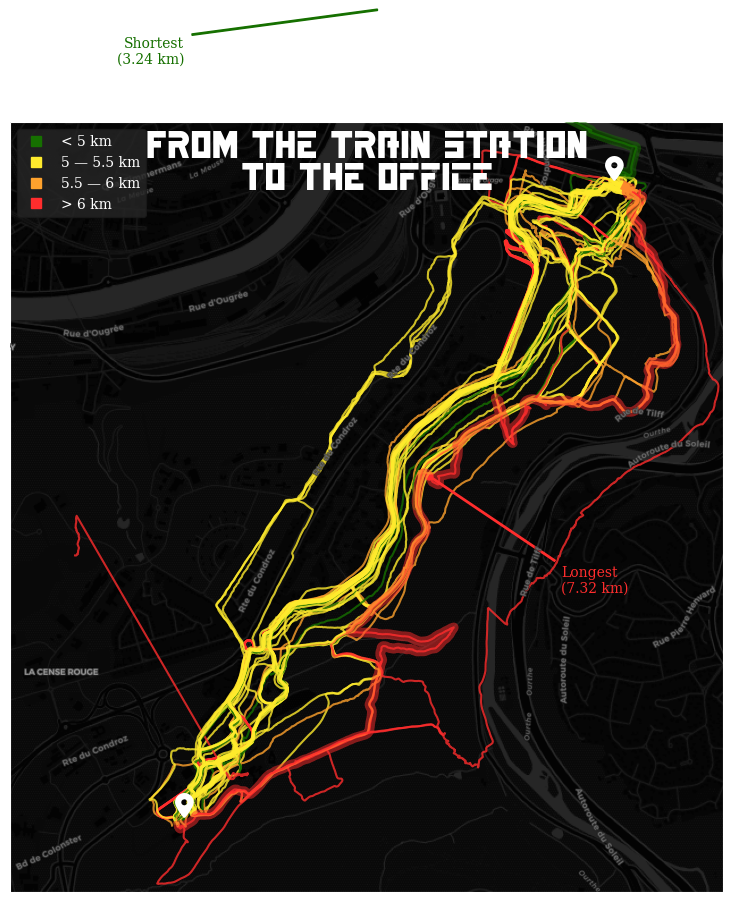

In [29]:
plt.style.use('dark_background')

distances = []
fig = plt.figure(figsize=(12, 10), frameon=False)
ax = plt.subplot(111, projection=proj)
ax.set_extent(domainangleur)
ax.text(0.5, 0.99, "From the train station\nto the office", ha="center", va="top", transform=ax.transAxes,
        fontsize=40, fontproperties=fonttitle, zorder=14)

ax.imshow(background3a.image, origin='upper', extent=background2.extent, transform=ccrs.epsg(3857), 
          zorder=2, alpha=1)
ax.imshow(background3c.image, origin='upper', extent=background2.extent, transform=ccrs.epsg(3857), 
          zorder=12, alpha=1)

for datafile in datafilelist:
    track = hikinggc.Track()
    track.get_coords(datafile)
    track.compute_dist()
    distances.append(track.dist[-1])
    thecolor = getcolordist(track.dist[-1])
    ax.plot(track.lon, track.lat, "-", color=thecolor, alpha=.8, transform=datacrs, zorder=4)

# Plot shortest and longest tracks
distances = np.array(distances)
dmin = distances.min()
indmin = np.argmin(distances)
dmax = distances.max()
indmax = np.argmax(distances)

track = hikinggc.Track()
track.get_coords(datafilelist[indmin])
track.compute_dist()
thecolor = getcolordist(track.dist[-1])
ax.plot(track.lon, track.lat, "-", lw=7, alpha=.5, color=thecolor, transform=datacrs, zorder=5)

t1 = ax.text(5.59875, 50.61319, "\uf3c5", fontproperties=fp1, transform=datacrs,
            fontsize=18, ha="center", va="bottom", zorder=7, color="w")
t1 = ax.text(5.56621, 50.58261, "\uf3c5", fontproperties=fp1, transform=datacrs,
            fontsize=18, ha="center", va="bottom", zorder=7, color="w")

indexmid = track.lon.shape[0]//2
ax.annotate(f"Shortest\n({np.round(track.dist[-1], 2)} km)",
            xy=(track.lon[indexmid], track.lat[indexmid]),  # theta, radius
            xytext=(track.lon[indexmid] - 0.015, track.lat[indexmid] - 0.002),    # fraction, fraction
            textcoords="data",
            xycoords='data',
            color=thecolor,
            transform=ccrs.PlateCarree(),
            arrowprops=dict(facecolor=thecolor, width=1, shrink=0.025, edgecolor=thecolor,
                            headwidth=0, headlength=0.1),
            horizontalalignment='left',
            ha="right", va="center", zorder=5)
ax.plot(track.lon[indexmid], track.lat[indexmid], "o", ms=5, color=thecolor, transform=datacrs)

track = hikinggc.Track()
track.get_coords(datafilelist[indmax])
track.compute_dist()
thecolor = getcolordist(track.dist[-1])
ax.plot(track.lon, track.lat, "-", lw=7, alpha=.5, color=thecolor, transform=datacrs, zorder=5)


indexmid = track.lon.shape[0]//2
ax.annotate(f"Longest\n({np.round(track.dist[-1], 2)} km)",
            xy=(track.lon[indexmid], track.lat[indexmid]),  # theta, radius
            xytext=(track.lon[indexmid] + 0.01, track.lat[indexmid] - 0.005),    # fraction, fraction
            textcoords="data",
            xycoords='data',
            color=thecolor,
            transform=ccrs.PlateCarree(),
            arrowprops=dict(facecolor=thecolor, edgecolor=thecolor,
                            width=1, shrink=0.025, headwidth=0, headlength=0.1),
            horizontalalignment='left',
            ha="left", va="center", zorder=5)
ax.plot(track.lon[indexmid], track.lat[indexmid], "o", ms=5, color=thecolor, transform=datacrs)

add_legend(colordict, ax, loc=2, ncol=1, legtitle=None)
plt.savefig(os.path.join(figdir, "train_angleur"), dpi=300, bbox_inches="tight")
plt.show()

### Hexbin

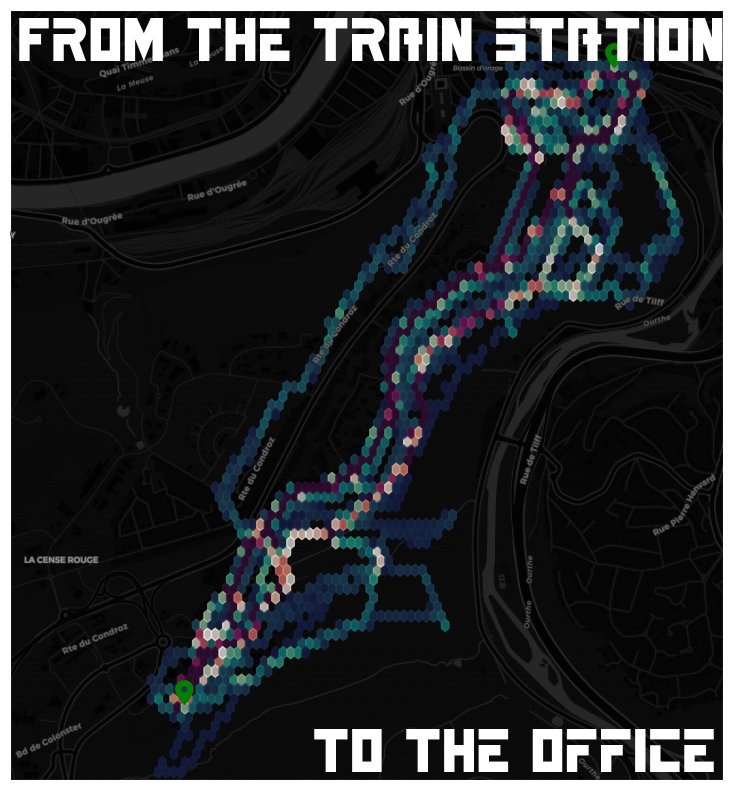

In [61]:
plt.style.use('dark_background')

distances = []
fig = plt.figure(figsize=(12, 10), frameon=False)
ax = plt.subplot(111, projection=proj)
ax.set_extent(domainangleur)
ax.text(0.01, 0.99, "From the train station", ha="left", va="top", transform=ax.transAxes,
        fontsize=64, fontproperties=fonttitle, zorder=14)

ax.text(0.99, 0.01, "to the office", ha="right", va="bottom", transform=ax.transAxes,
        fontsize=64, fontproperties=fonttitle, zorder=14)

t1 = ax.text(5.59875, 50.61319, "\uf3c5", fontproperties=fp1, transform=datacrs,
            fontsize=18, ha="center", va="bottom", zorder=7, color="g")
t1 = ax.text(5.56621, 50.58261, "\uf3c5", fontproperties=fp1, transform=datacrs,
            fontsize=18, ha="center", va="bottom", zorder=7, color="g")

ax.imshow(background3a.image, origin='upper', extent=background2.extent, transform=ccrs.epsg(3857), 
          zorder=2, alpha=1)
ax.imshow(background3c.image, origin='upper', extent=background2.extent, transform=ccrs.epsg(3857), 
          zorder=12, alpha=1)


ax.hexbin(lonall, latall, cmap=cmocean.cm.curl, gridsize=70, mincnt=2, 
          vmax=300, transform=datacrs, zorder=4, alpha=.75)
plt.savefig(os.path.join(figdir, "train_angleur_hexbin_curl"), dpi=300, bbox_inches="tight")
plt.show()

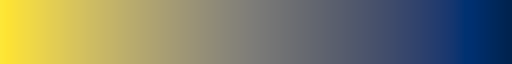

In [ ]:

lonall = []
latall = []
for datafile in datafilelist:
    track = hikinggc.Track()
    track.get_coords(datafile)
    
    lonall.extend(track.lon)
    latall.extend(track.lat)